# Анализ воронки


**Цель: исследовать поведение пользователей в обновленном приложении.**


Продолжение исследования мобильной игры Quiz Freeze - это сборник вопросов в различных форматах и темах, на которые игрокам нужно давать ответы. Игра одиночная, то есть каждый игрок отвечает на вопросы самостоятельно. Пользователи проходят этапы в игре:
Регистрация - Старт обучения - Завершение обучения - Выбор уровня сложности - Покупка доп. вопросов

Обучение не является обязательным этапом, пользователь может вернуться к шагу обучения если захочет неограниченное число раз.

- *Гипотеза 1: должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?*
- *Гипотеза 2: Кажется, повторное прохождение обучения положительно влияет на оплату.*
- *Гипотеза 3: Если пользователь сначала выбирает сложность вопросов, будет ли он потом проходить обучение?*

**Для проверки гипотез необходимо решить три задачи:**
- 1.Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
- 2.Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
- 3.Выяснить, как часто пользователи начинают обучение после выбора уровня сложности

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
event = pd.read_csv('7_4_Events.csv')
purchase = pd.read_csv('purchase.csv')

In [3]:
# Проверим типы данных
event.info() 
purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252334 entries, 0 to 252333
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              252334 non-null  int64  
 1   event_type      252334 non-null  object 
 2   selected_level  31086 non-null   object 
 3   start_time      252334 non-null  object 
 4   tutorial_id     125103 non-null  float64
 5   user_id         252334 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 11.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956 entries, 0 to 5955
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              5956 non-null   int64 
 1   user_id         5956 non-null   int64 
 2   event_datetime  5956 non-null   object
 3   amount          5956 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 186.2+ KB


In [4]:
# Отобразим начало таблиц для удобства работы
display(event.head(5)) 
display(purchase.head(5))

,id,event_type,selected_level,start_time,tutorial_id,user_id
0,28903,registration,NaN,2016-05-11T23:40:55,NaN,12583
1,28904,registration,NaN,2016-05-11T23:49:58,NaN,12584
2,28905,registration,NaN,2016-05-12T00:53:07,NaN,12585
3,28906,tutorial_start,NaN,2016-05-12T01:32:20,17562.0,12585
4,28907,tutorial_finish,NaN,2016-05-12T01:34:53,17562.0,12585


,id,user_id,event_datetime,amount
0,15674,12584,2016-05-12T10:34:16,100
1,15675,12985,2016-05-13T08:25:56,50
2,15676,12828,2016-05-13T16:33:46,50
3,15677,12598,2016-05-14T01:09:37,150
4,15678,13037,2016-05-14T01:24:46,100


In [5]:
# Выполнять исследование будем на основе данных пользователей, которые зарегистрировались в 2018 году.
mask_year = (event['event_type'] == 'registration') & (event['start_time'] >= '2018-01-01') & (event['start_time'] < '2019-01-01') 
registered_users = event[mask_year]['user_id'].values # Пользователи зарегестрированные в 2018 году
# Применим фильтр зарегистрированных в 2018 на таблицы
event_registered = event[event['user_id'].isin(registered_users)] 
purchase_registered = purchase[purchase['user_id'].isin(registered_users)] 


In [6]:
# Удаление дубликатов
event_registered = event_registered.drop_duplicates(subset=['event_type','start_time','user_id'])
purchase_registered = purchase_registered.drop_duplicates()

In [7]:
# Преобразование типа в формат datetime
event_registered['start_time'] = pd.to_datetime(event_registered['start_time'],yearfirst=True)
purchase_registered['event_datetime'] = pd.to_datetime(purchase_registered['event_datetime'],yearfirst=True)

## Проверка гипотезы № 1: 


In [8]:
# Добавим тип события в таблицы покупок
purchase['event_type'] = 'purchase'
purchase_registered['event_type'] = 'purchase'


In [9]:
# Переименуем столбцы 
event_registered = event_registered.rename(columns={'id':'event_id'})
purchase_registered = purchase_registered.rename(columns={'id':'purchase_id','event_datetime':'start_time'})
# Объединим события и покупки в один датафрейм
total_events_df = pd.concat([event_registered,purchase_registered],sort=False)
# Отсортируем события по возрастанию времени
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')
display(total_events_df.head(5))


,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN


In [10]:
# Этапы игры, которые проходят пользователи
display(total_events_df.event_type.value_counts())

registration       19926
tutorial_start     18047
tutorial_finish    14904
level_choice        8342
pack_choice         5737
purchase            1600
Name: event_type, dtype: int64

Разделим пользователей на 3 группы: 
- закончившие обучение
- начавшие, но не закончившие обучение
- не начинавших обучение

In [11]:
# Выделим группу пользователей закончивших обучение
finish_tutorial_users = total_events_df[total_events_df['event_type']=='tutorial_finish']['user_id'].unique()
set_finish_tutorial_users = set(finish_tutorial_users)
# Выделим группу пользователей начавших, но не закончивших обучение
start_tutorial_users = total_events_df[total_events_df['event_type']=='tutorial_start']['user_id'].unique()
set_not_finish_tutorial_users = set(start_tutorial_users).difference(set_finish_tutorial_users)
# Выделим группу пользователей не начинавших обучение
set_not_start_tutorial_users = set(total_events_df['user_id'].unique()).difference(set(start_tutorial_users))

In [12]:
# Создадим датафрейм с группировкой по пользователям и этапам прохождения игры, используем агрегатную функцию min 
# так как важно хотя бы 1 пройденное/начатое обучение   
tut_groups_df = total_events_df.pivot_table(
    values='start_time',
    index='user_id',
    columns='event_type',
    aggfunc='min'
).reset_index()
# Добавим столбец tutorial_group, показывающий принадлежность пользователя к сформированным группам
tut_groups_df['tutorial_group'] = tut_groups_df.apply(lambda x: 'finished' if x['user_id'] in set_finish_tutorial_users \
    else 'not_finished' if x['user_id'] in set_not_finish_tutorial_users \
    else 'not_started', axis=1)
tut_groups_df.reset_index(drop=True)

display(tut_groups_df.head(5))

event_type,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start,tutorial_group
0,27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT,not_started
1,27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40,finished
2,27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11,finished
3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,finished
4,27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40,finished


Найдем скорость прохождения этапов игры у каждого пользователя:
- время от выбора уровня до выбора пакета вопросов 
- время от выбора пакета вопросов до покупки 
- время от регистрации до покупки 

In [13]:
# Вычислим время от выбора уровня 'lc' до выбора пакета вопросов 'pc'
tut_groups_df['timedelta pc_lv'] = tut_groups_df['pack_choice'] - tut_groups_df['level_choice']
# Вычислим время от выбора пакета вопросов 'pc' до покупки 'pu'
tut_groups_df['timedelta pu_pc'] = tut_groups_df['purchase'] - tut_groups_df['pack_choice']
# Вычислим время от регистрации 're' до покупки 'pu'
tut_groups_df['timedelta pu_re'] = tut_groups_df['purchase'] - tut_groups_df['registration']

display(tut_groups_df.head(5))

event_type,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start,tutorial_group,timedelta pc_lv,timedelta pu_pc,timedelta pu_re
0,27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT,not_started,NaT,NaT,NaT
1,27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40,finished,NaT,NaT,NaT
2,27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11,finished,NaT,NaT,NaT
3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,finished,0 days 00:01:21,NaT,NaT
4,27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40,finished,NaT,NaT,NaT


In [14]:
# Создадим датафрейм с timedelta в мин с распределением всех пользователей по группам обучения
timedelta_tut_groups = tut_groups_df.groupby(['tutorial_group']) \
    [['timedelta pc_lv','timedelta pu_pc','timedelta pu_re']].mean()

In [15]:
# Переведем формат времени столбцов timedelta в числовой тип путем деления на pd.Timedelta('1hour') 
for col in timedelta_tut_groups.columns:
    timedelta_tut_groups[col] = timedelta_tut_groups[col] / pd.Timedelta('1hour')
# Отобразим результат
display(timedelta_tut_groups)
  

event_type,timedelta pc_lv,timedelta pu_pc,timedelta pu_re
tutorial_group,,,
finished,0.088374,89.299900,96.500902
not_finished,0.084804,93.246363,101.548115
not_started,0.089951,100.825997,105.100530


Наибольшее количество времени на прохождение этапов тратят пользователи, не прошедшие обучение.


## Проверка гипотезы № 2:

In [16]:
# Создадим датафрейм с подсчетом количества попыток обучения
tutorial_attemps_df = total_events_df.groupby('user_id')['tutorial_id'].nunique().reset_index()
tutorial_attemps_df.columns=['user_id','tutorial_attemps']
# Выделим группу пользователей совершивших покупку платных вопросов 
set_clients = set(total_events_df[total_events_df['event_type']=='purchase']['user_id'])
# Добавим признак принадлежности пользователя к клиентам : yes - совершил покупку, no - нет
tutorial_attemps_df['users_clients'] = tutorial_attemps_df.apply(lambda x: 'yes' if x['user_id'] in set_clients \
    else 'no', axis=1)
# Отобразим результат
display(tutorial_attemps_df.head(5))

,user_id,tutorial_attemps,users_clients
0,27832,0,no
1,27833,1,no
2,27834,1,no
3,27835,1,no
4,27836,2,no


In [17]:
# Просмотрим статистику по количеству попыток обучения
tutorial_attemps_df['tutorial_attemps'].describe()

count    19926.000000
mean         0.905801
std          1.279903
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          9.000000
Name: tutorial_attemps, dtype: float64

В среднем пользователи проходят обучение 1 раз, а максимальное количество попыток 9.

In [18]:
# Если пользователь проходит 3 и больше обучений заменим его кол-во попыток на '3 and more'
tutorial_attemps_df['tutorial_attemps'] = tutorial_attemps_df['tutorial_attemps'].apply(lambda x: x if x < 3 \
    else '3 and more')


In [19]:
# Создадим датафрейм отражающий кол-во оплат (users_clients 'yes') среди групп пользователей в зависимости от кол-ва обучений
mask_client_yes = tutorial_attemps_df[tutorial_attemps_df['users_clients']=='yes']
tutorial_count_groups = mask_client_yes.groupby(['tutorial_attemps'])['users_clients'].count().reset_index()
tutorial_count_groups.columns=['tutorial_attemps','users_clients_yes']
display(tutorial_count_groups)

,tutorial_attemps,users_clients_yes
0,0,22
1,1,1207
2,2,218
3,3 and more,153


In [20]:
# Создадим датафрейм с подсчетом всех пользователей в каждой группе обучения
all_users_df = tutorial_attemps_df.groupby(['tutorial_attemps'])['users_clients'].count().reset_index()
all_users_df.columns=['tutorial_attemps','users_all']
display(all_users_df)

,tutorial_attemps,users_all
0,0,8068
1,1,9103
2,2,1589
3,3 and more,1166


In [22]:
# Объединим датафреймы 
users_clients_cr = tutorial_count_groups.merge(all_users_df, on='tutorial_attemps')
# Вычислим конверсию для каждой группы 
users_clients_cr['cr_%'] = round(users_clients_cr['users_clients_yes'] / users_clients_cr['users_all'] * 100, 2)

In [23]:
# Посмотрим получившийся результат
display(users_clients_cr)

,tutorial_attemps,users_clients_yes,users_all,cr_%
0,0,22,8068,0.27
1,1,1207,9103,13.26
2,2,218,1589,13.72
3,3 and more,153,1166,13.12


Конверсия (cr_%) от пользователей не прошедших обучение существенно ниже чем у любой другой группы.

## Проверка гипотезы № 3:

In [24]:
# Cоздадим 2 датафрейма tutorial_start_df и level_choice_df
tutorial_start_df = total_events_df[total_events_df['event_type']=='tutorial_start'][['user_id','start_time']]\
    .rename(columns={'start_time':'tutorial_start_time'})
level_choice_df = total_events_df[total_events_df['event_type']=='level_choice'][['user_id','start_time']]\
    .rename(columns={'start_time':'level_choice_time'})
# Объединим датафреймы соответственно и найдем разницу во времени timedelta между выбором уровня и стартом обучения
timedif_df = pd.merge(tutorial_start_df,level_choice_df,on='user_id')
timedif_df['timedelta'] = timedif_df['tutorial_start_time'] - timedif_df['level_choice_time']
# Оставим только записи с положительным значением timedelta (когда обучение началось после выбора уровня)
timedif_df = timedif_df[timedif_df['timedelta'] > pd.Timedelta(0)].reset_index(drop=True)
# Отобразим получившийся датафрейм
display(timedif_df.head(5))

,user_id,tutorial_start_time,level_choice_time,timedelta
0,27845,2018-01-02 07:08:00,2018-01-02 06:19:18,0 days 00:48:42
1,27842,2018-01-02 09:01:51,2018-01-02 08:46:03,0 days 00:15:48
2,27842,2018-01-02 18:08:01,2018-01-02 08:46:03,0 days 09:21:58
3,27852,2018-01-02 20:34:31,2018-01-02 18:39:44,0 days 01:54:47
4,27862,2018-01-03 11:17:41,2018-01-03 04:19:32,0 days 06:58:09


In [25]:
# Кол-во обучений из timedif_df разделим на общее кол-во начатых обучений
late_tutorial_percent = len(timedif_df) / len(total_events_df[total_events_df['event_type']=='tutorial_start'])

print(f'Процент обучений, начатых после выбора уровня сложности: {late_tutorial_percent:.2%}')

Процент обучений, начатых после выбора уровня сложности: 15.47%


# Выводы

## Гипотеза 1

Рассмотрим диаграмму для ответа на вопрос "Отличается ли время прохождения различных этапов у пользователей, которые прошли обучение, и пользователей, не начинавших обучение?»

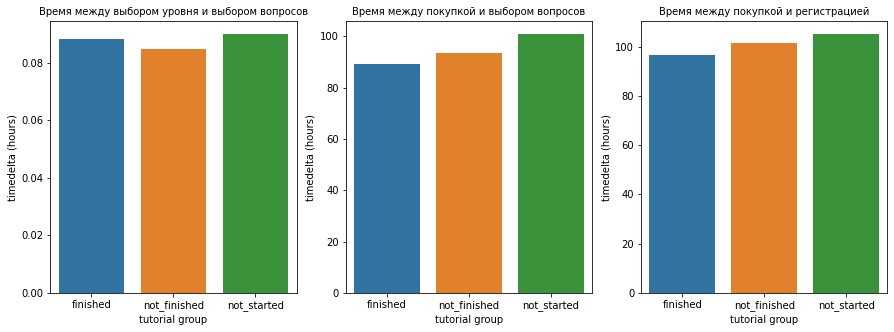

In [27]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.barplot(
    data = timedelta_tut_groups,
    y = 'timedelta pc_lv',
    x = timedelta_tut_groups.index,
    ax = axes[0]
)
axes[0].set_title('Время между выбором уровня и выбором вопросов', fontsize=10)
axes[0].set_xlabel('tutorial group')
axes[0].set_ylabel('timedelta (hours)')
sns.barplot(
    data = timedelta_tut_groups,
    y = 'timedelta pu_pc',
    x = timedelta_tut_groups.index,
    ax = axes[1]
)
axes[1].set_title('Время между покупкой и выбором вопросов', fontsize=10)
axes[1].set_xlabel('tutorial group')
axes[1].set_ylabel('timedelta (hours)')
sns.barplot(
    data = timedelta_tut_groups,
    y = 'timedelta pu_re',
    x = timedelta_tut_groups.index,
    ax = axes[2]
)
axes[2].set_title('Время между покупкой и регистрацией', fontsize=10)
axes[2].set_xlabel('tutorial group')
axes[2].set_ylabel('timedelta (hours)');

Судя по диаграмме, наибольшее количество времени на проождение игры тратят пользователи не прошедшие обучение, и те пользователи ,кто начал, но не закончил, справляются быстрее с прохождением этапов. Даже учитывая факт, что обучение прибавляет дополнительное время на прохождение этапов. Посмотрим более точные показатели:

In [28]:
display(timedelta_tut_groups)

event_type,timedelta pc_lv,timedelta pu_pc,timedelta pu_re
tutorial_group,,,
finished,0.088374,89.299900,96.500902
not_finished,0.084804,93.246363,101.548115
not_started,0.089951,100.825997,105.100530


В среднем пользователь, прошедший обучение, тратит на 5 часов меньше, чем не закончивший обучение, и на 9 часов чем совсем не проходивший. 

## Гипотеза 2

Рассмотрим диаграмму для ответа на вопрос: "Существует ли зависимость между вероятностью оплаты и количеством обучений, которые начинал или завершал пользователь?"

In [29]:
display(users_clients_cr)

,tutorial_attemps,users_clients_yes,users_all,cr_%
0,0,22,8068,0.27
1,1,1207,9103,13.26
2,2,218,1589,13.72
3,3 and more,153,1166,13.12


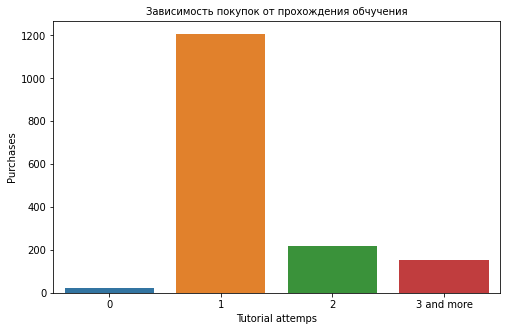

In [30]:
fig = plt.figure(figsize=(8,5))
bar = sns.barplot(
    data = users_clients_cr,
    y = 'users_clients_yes',
    x = 'tutorial_attemps',
)
bar.set_title('Зависимость покупок от прохождения обчучения', fontsize=10)
bar.set_xlabel('Tutorial attemps')
bar.set_ylabel('Purchases');

Анализ количества попыток прохождения обучения, показал что конверсия у пользователей (начавших/завершивших) обучение хотя бы 1 раз существенно выше, чем у пользователей не прошедших ни разу: 13,26% против 0,27%. 
Кроме того, стоит отметить, что в ходе выполнения анализа была замечена группа пользователей, которая возвращается к обучению 3 и более раз (max число попыток 9), что говорит о непонятном процессе прохождения игры для пользователей, однако и они также совершают покупки чаще. 
Прохождение обучения в целом положительно влияет на оплату в игре.

## Гипотеза 3

Как часто пользователи начинают обучение после того, как выбрали уровень сложности тренировок? 

In [31]:
print(f'Процент обучений, начатых после выбора уровня сложности: {late_tutorial_percent:.2%}')

Процент обучений, начатых после выбора уровня сложности: 15.47%


В идеальном пользовательском путе событие выбора уровня идет после прохождения обучения, однако статистика показывает, что 15,47% всех обучений проходится позже. Это еще раз подтверждает, что пользователю необходимо возвращаться к обучению из-за не ясного интерфейса

## Выводы

Пользователи прошедшие обучение быстрее проходят путь от регистрации до покупки и вероятней совершают покупку, чем пользователи без обучения. 
Рекомендовано пересмотреть этап обучения и сделать его обязательным, кроме того необходимо улучшить дизайн остальных разделов, что сократит время до покупки, так как группа пользователей проходящих обучение 3 и более раз должна исчезнуть.